### Upos comparison

As a first step exploring a treebank, one may be interested in explore its parts of speech. The simple upos distribution is not informative enough, as neither is to know the features of each upos.

Here, another way to explore the upos in an informative way.

1- We build a feature vector for each upos, either a binary vector or a ratio vector. The features used are those present in the search space (similar to Grex)

2- We compute the pairwise distance between each vector.

3- Then, we perform hierarchical clustering to get upos clusters, that are regrouped by their similarity in different cluster nodes. Each cluster node regrouped two sets of upos.

4- Given these two sets of upos, we extract the most distinctive patterns using Grex. E.g. scope: X[upos=NOUN|PROPN], conclusion: X[upos=NOUN] or scope: X[upos=NOUN|PROPN|SYM], conclusion: X[upos=NOUN], so on. 


Results?:

- Seems to work

- Results are pretty good as for a first exploration

- Comparing UD and SUD is also interesting

Some problems:

- It takes too long as it is coded (~5 minutes to build the clusters for the French GSD. Most of the time is due to reading the corpus and extracting the features, the rest is fast) 

- Some clusters don't seem interesting

- Choosing the good distance and the linkage parameter is challenging. 

Comments:

- When the corpus is big, maybe a sample is enough

- We extract distinctive patterns between two upos clusters, but what about the similarities? 

In [1]:
import grewpy
import yaml
import sys
import numpy as np

sys.path.insert(1, '/Users/madalina/Documents/M2TAL/stage/grex/grex2')
import pyximport
pyximport.install()
import grex.data
import grex.utils
import grex.features

connected to port: 59604


In [3]:
path = "/Users/madalina/Documents/M1TAL/stage-SK/Treebanks/UD_French-GSD-master"
grewpy.set_config('ud')
corpus = grewpy.Corpus(path)
draft = grewpy.CorpusDraft(corpus)
# all nodes having a upos, except PUNCT
matches = corpus.search(grewpy.Request("X[upos<>PUNCT]"), clustering_parameter=['X.upos'])
# !python ../grex2/check_features.py --patterns patterns_upos.txt /home/santiago/data/treebanks/sud-treebanks-v2.14/SUD_French-GSD/

In [4]:

# The search space is defined using the yml file.
with open("patterns_upos.txt") as instream:
    config = yaml.load(instream, Loader=yaml.Loader)
    
templates = grex.utils.FeaturePredicate.from_config(config["templates"])
feature_predicate = grex.utils.FeaturePredicate.from_config(config["features"], templates=templates)

# Feature extraction
data = { k : list() for k in matches }
for upos, mts in matches.items():
    for match in mts:
        features = grex.data.extract_features(draft, match, feature_predicate)
        formatted_features = [
            f"{':'.join(k)}={v}" if not isinstance(v, set) else
            f"{':'.join(k)}={val}" for k, v in features.items() for val in (v if isinstance(v, set) else [v])
        ]
        data[upos].append(formatted_features)

unique_upos = sorted(set([k for k in data]))
unique_features = sorted(set([feat for _, matches in data.items() for m in matches for feat in m]))

# mappings
idx2feature = {i : feat for i, feat in enumerate(unique_features) }
feature2idx = {feat : i for i, feat in idx2feature.items()}
idx2upos = {i : feat for i, feat in enumerate(unique_upos) }
upos2idx = {feat : i for i, feat in idx2upos.items()}

print(f"{unique_upos}")
print(f"{unique_features}")

['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PRON', 'PROPN', 'SCONJ', 'SYM', 'VERB', 'X']
['node:X:child:Definite=Def', 'node:X:child:Definite=Ind', 'node:X:child:Emph=No', 'node:X:child:Emph=Yes', 'node:X:child:ExtPos=ADJ', 'node:X:child:ExtPos=ADP', 'node:X:child:ExtPos=ADV', 'node:X:child:ExtPos=CCONJ', 'node:X:child:ExtPos=DET', 'node:X:child:ExtPos=INTJ', 'node:X:child:ExtPos=NOUN', 'node:X:child:ExtPos=NUM', 'node:X:child:ExtPos=PRON', 'node:X:child:ExtPos=PROPN', 'node:X:child:ExtPos=SCONJ', 'node:X:child:ExtPos=VERB', 'node:X:child:Foreign=Yes', 'node:X:child:Gender=Fem', 'node:X:child:Gender=Masc', 'node:X:child:Idiom=Yes', 'node:X:child:InIdiom=Yes', 'node:X:child:InTitle=Yes', 'node:X:child:Lang=ar', 'node:X:child:Lang=br', 'node:X:child:Lang=ca', 'node:X:child:Lang=cs', 'node:X:child:Lang=de', 'node:X:child:Lang=el', 'node:X:child:Lang=en', 'node:X:child:Lang=es', 'node:X:child:Lang=fro', 'node:X:child:Lang=ge', 'node:X:child:Lang=grc', 'node:X:child

In [5]:
# Binary matrix, where the lines are the upos, features the columns, and values 0/1 indicating the presence of the feature for a given upos.
X = np.zeros((len(data.keys()), len(unique_features)))
for upos, samples in data.items():
    for m in samples:
        for feature in m:
            X[upos2idx[upos], feature2idx[feature]] = 1
print(f"{X.shape=}")

X.shape=(15, 399)


In [6]:
# Ratio matrix, where observation = support(feature)/support(upos)
X = np.zeros((len(data.keys()), len(unique_features)))
for upos, samples in data.items():
    n_samples = len(matches)
    for m in samples:
        for feature in m:
            X[upos2idx[upos], feature2idx[feature]] += 1
    X[upos2idx[upos]] = X[upos2idx[upos]] / n_samples
print(f"{X.shape=}")

X.shape=(15, 399)


see [scipy pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) for a huge amount of distance measures

see [scipy linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) documentation regarding the clustering method

It seems that the linkage hierarchical clustering is really sensible to outliners. I choose as method of linkage 'complete'

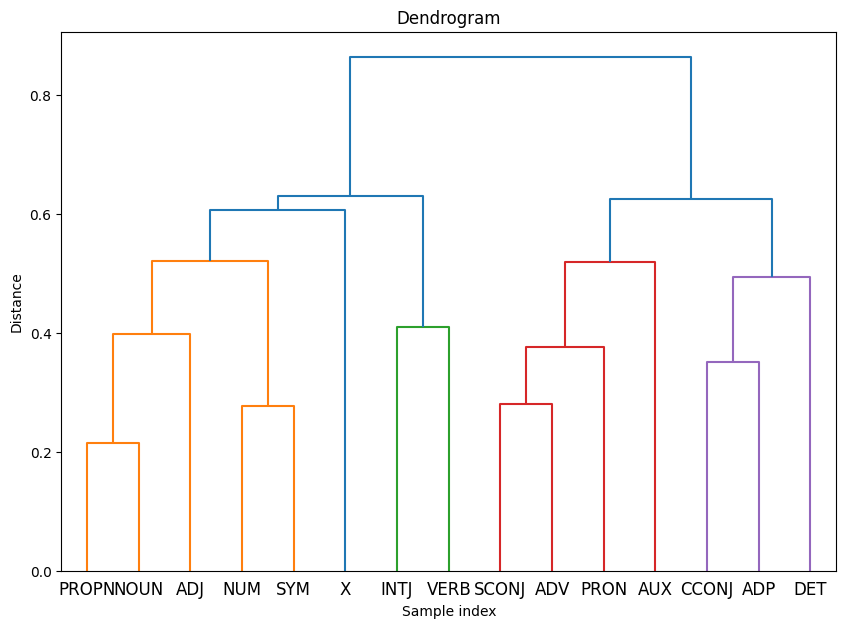

In [7]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
import matplotlib.pyplot as plt

# Hamming or jacard for categorical data, cosine for sparse matrices (normally used in NLP)
# I compute the distance for each pair of lines, each POS
distance_matrix = pdist(X, metric='cosine')
# Complete -> we cluster 
linked = linkage(distance_matrix, method="complete", optimal_ordering=True)

plt.figure(figsize=(10, 7))

dn = dendrogram(linked,
                orientation='top',
                labels=[name for name in unique_upos],
                distance_sort='descending',
                show_leaf_counts=True,
                get_leaves=True)

plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [25]:
class GrexQuery:
    def __init__(self, scope: str, conclusion: str = None, meta_conclusion: str = None):
        if conclusion is None and meta_conclusion is None:
            raise ValueError("At least one conclusion must be provided.")
        self.scope = scope
        self.conclusion = conclusion
        self.meta_conclusion = meta_conclusion

def get_clusters(linkage_matrix, mapping=None):
    """Explore the linked tree and extract all clusters"""
    _, cluster_nodes = to_tree(linkage_matrix, rd=True)
    clusters = list()
    for node in cluster_nodes:
        if not node.is_leaf():
            right_children_features = tuple(node.right.pre_order(lambda x: mapping[x.id] if mapping else x.id))
            left_children_features = tuple(node.left.pre_order(lambda x: mapping[x.id] if mapping else x.id))
            clusters.append((right_children_features, left_children_features))
    return clusters

upos_clusters = get_clusters(linked, idx2upos)
# scopes and conclusions
queries = [GrexQuery("|".join(cluster[0]) + "|" + "|".join(cluster[1]), "|".join(cluster[1])) for cluster in upos_clusters]

In [41]:
queries[3].scope, queries[3].conclusion

('ADP|SCONJ', 'SCONJ')

We can use Grex to extract distinctive patterns for each cluster node (see dendogram).
E.g.
- scope: X[upos=ADJ|NUM], conclusion: X[upos=ADJ]
- scope: X[upos=NOUN|PROPN], conclusion: X[upos=NOUN]
- scope: X[upos=NOUN|PROPN|SYM], conclusion: X[upos=NOUN]
- ...


In [ ]:
import pandas as pd
import json

with open("patterns_upos.txt") as instream:
    config = yaml.load(instream, Loader=yaml.Loader)

# Change indices here to select the scope and the conclusion
config['scope'] = f"pattern {{ X[upos={queries[3].scope}] }}"
config['conclusion'] = f"X[upos={queries[3].conclusion}]"

with open("temp.yml", mode='w' ) as temp:
    temp.write(yaml.dump(config))
print(config['scope'], config['conclusion'])
!python ../grex2/extract_rules_via_lasso.py --patterns temp.yml --output tmp.json --max-degree 2 /home/santiago/data/treebanks/sud-treebanks-v2.14/SUD_French-GSD/

In [52]:
with open("tmp.json") as f:
    cluster_data = json.load(f)

print("scope s:", cluster_data['pattern_s'], "conclusion q:", cluster_data['pattern_q'])
print("occs s:", cluster_data['data_len'])
print("occs sq:", cluster_data['n_yes'])

# first 5 rules
pd.DataFrame.from_dict(cluster_data['rules'])

scope s: pattern { X[upos=ADP|SCONJ] } conclusion q: X[upos=SCONJ]
occs s: 66674
occs sq: 2981


,pattern,n_pattern_occurence,n_pattern_positive_occurence,decision,alpha,value,coverage,precision,delta,g-statistic,p-value,cramers_phi
0,node:X:child:VerbForm=Fin,2049,2000,yes,0.028,0.417008,67.091580,97.608590,1908.389042,11972.026722,0.000000e+00,2.417202
1,node:X:child:upos=NOUN,41907,133,no,0.021,-0.033435,65.586485,99.682631,-1740.665402,2852.291402,0.000000e+00,0.260888
2,"node:X:child:rel_shallow=comp:obj,node:X:child...",41896,133,no,0.020,-0.079657,65.569215,99.682547,-1740.173591,2851.355054,0.000000e+00,0.260879
3,"node:X:child:VerbForm=Fin,node:X:child:rel_sha...",2049,2000,yes,0.019,2.463590,67.091580,97.608590,1908.389042,11972.026722,0.000000e+00,2.417202
4,node:X:own:rel_shallow=udep,30700,125,no,0.011,-0.018876,48.003705,99.592834,-1247.599514,1948.498455,0.000000e+00,0.251931
5,"node:X:own:rel_shallow=udep,node:X:child:rel_s...",30693,125,no,0.011,-0.004034,47.992715,99.592741,-1247.286543,1947.915216,0.000000e+00,0.251922
6,node:X:parent:upos=ADV,2206,777,yes,0.010,0.162107,26.065079,35.222121,678.369559,2097.315142,0.000000e+00,0.975055
7,"node:X:parent:position=before,node:X:parent:up...",2197,776,yes,0.009,0.626944,26.031533,35.320892,677.771950,2099.411861,0.000000e+00,0.977538
8,node:X:child:rel_shallow=comp:obj,65639,2401,no,0.006,-0.514388,99.285636,96.342114,-533.725065,108.082195,0.000000e+00,0.040579
9,"node:X:own:rel_shallow=unk,node:X:parent:posit...",734,571,yes,0.005,0.286457,19.154646,77.792916,538.182800,2786.410407,0.000000e+00,1.948384


### Extra

I can do the same thing with scikit-learn

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # a linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, labels=[name for name in unique_upos], **kwargs)

agglo = AgglomerativeClustering(compute_distances=True, linkage="complete", metric="cosine")
agglo.fit(X)

plt.figure(figsize=(10, 7))
plot_dendrogram(agglo)
plt.xlabel("Features")
plt.show()